In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
def trend(time, slope):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                    np.cos(season_time*2*np.pi),
                    1 / np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange((4 * 365 )+ 1, dtype = 'float64')
series = trend(time,0.05)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 10

data = baseline + trend(time,slope)
data += seasonality(time, period=365, amplitude=amplitude)
data += noise(time, noise_level=noise_level, seed=42)

df_data = pd.DataFrame(data, columns=['y_0'])
df_data['y'] = df_data['y_0'].shift(-1)

In [4]:
# plt.figure(figsize=(15,5))
# plt.plot(df_data)

In [5]:
df_data['ma'] = df_data['y_0'].rolling(10).mean()
df_data['diff'] = df_data['y_0'].diff(1)
df_data['detrand'] = df_data['y_0'] -  df_data['ma']
df_data['diff_ma'] = df_data['diff'].rolling(50).mean()
df_data['new_ma'] = df_data['ma'] + df_data['diff_ma']

In [6]:
df_data

,y_0,y,ma,diff,detrand,diff_ma,new_ma
0,34.967142,28.704394,NaN,NaN,NaN,NaN,NaN
1,28.704394,36.645033,NaN,-6.262748,NaN,NaN,NaN
2,36.645033,45.473635,NaN,7.940640,NaN,NaN,NaN
3,45.473635,27.971072,NaN,8.828601,NaN,NaN,NaN
4,27.971072,28.034594,NaN,-17.502563,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1456,149.602438,145.962183,147.960583,25.222551,1.641855,0.514570,148.475154
1457,145.962183,155.129773,147.836635,-3.640255,-1.874452,-0.144410,147.692225
1458,155.129773,149.045773,147.969433,9.167590,7.160339,0.402197,148.371630
1459,149.045773,160.015440,148.702743,-6.084000,0.343030,0.264597,148.967340


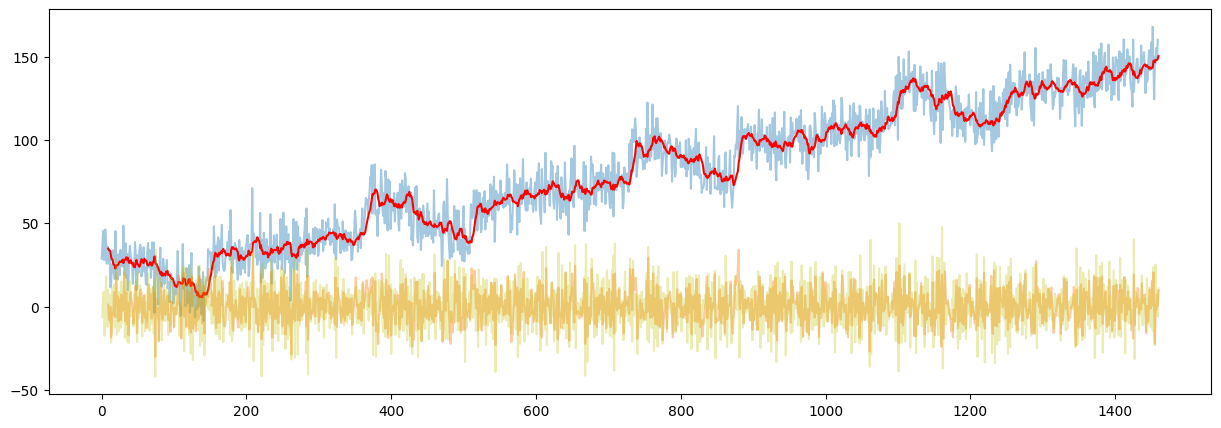

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df_data.index, df_data['y'], alpha=0.4)
plt.plot(df_data.index, df_data['detrand'], alpha=0.4)
plt.plot(df_data.index, df_data['ma'], color = "red")
plt.plot(df_data.index, df_data['diff'], color = "y", alpha=0.3)
# plt.plot(df_data.index, df_data['diff_ma'], alpha=0.3)
# plt.plot(df_data.index, df_data['new_ma'])


In [8]:
mean_absolute_error(df_data['y_0'][1000:],df_data['ma'][1000:])

7.684255382994188

In [9]:
mean_absolute_error(df_data['y_0'][1000:],df_data['new_ma'][1000:])

7.5206354205146395

In [10]:
df_predict = df_data.drop(columns='y').copy()
for lag in np.arange(0, 15, 1):
    df_predict[f'lag_{lag}'] = df_data['y'].transform(lambda x: x.shift(lag))
df_predict['y_true'] = df_data['y'].transform(lambda x : x.shift(-1))
print('************ ROLLING LAGS ************')
for roll in [7, 14, 30, 60, 180, 365]:
    df_predict[f'rolling_zero_{roll}'] = df_data['y'].transform(lambda x: x.rolling(roll).sum())
    df_predict[f'rm_{roll}'] = df_data['y'].transform(lambda x: x.rolling(roll).mean())
    df_predict[f'std_{roll}'] = df_data['y'].transform(lambda x: x.rolling(roll).std())
    df_predict[f'diff_rm_{roll}'] = df_data['y'].transform(lambda x : x.diff().rolling(roll).mean()) 
    df_predict[f'max_{roll}'] = df_data['y'].transform(lambda x: x.rolling(roll).max())

************ ROLLING LAGS ************


In [11]:
df_predict =  df_predict.dropna(axis=0).reset_index(drop=True)
X_train = df_predict.drop(columns='y_true')[:800]
y_train = df_predict['y_true'][:800]
X_test = df_predict.drop(columns='y_true')[800:]
y_test = df_predict['y_true'][800:]

In [12]:
mean_absolute_error(df_predict['y_true'][1000:],df_predict['ma'][1000:]),mean_absolute_error(df_predict['y_true'][1000:],df_predict['new_ma'][1000:])

(8.282949510586382, 8.282372218337265)

In [13]:
mean_absolute_error(df_predict['y_true'][:1000],df_predict['ma'][:1000]),mean_absolute_error(df_predict['y_true'][:1000],df_predict['new_ma'][:1000])

(8.829351007956113, 8.846148922247776)

In [14]:
# Fitting the model
base_model = LinearRegression()
base_model.fit(X_train, y_train)

# Returning the R^2 for the model
base_r2 = base_model.score(X_train, y_train)
print('R^2: {0}'.format(base_r2))
base_r2 = base_model.score(X_test, y_test)
print('R^2: {0}'.format(base_r2))

R^2: 0.834504837979089
R^2: 0.5064508909367891


In [15]:
y_pred = base_model.predict(X_train)
print(mean_absolute_error(y_train,y_pred=y_pred))
y_pred = base_model.predict(X_test)
print(mean_absolute_error(y_test,y_pred=y_pred))

8.386797027100876
8.061709168439306


In [16]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [17]:
# linear_assumption(base_model, X_train, y_train)

In [18]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print(p_value)
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [19]:
# normal_errors_assumption(base_model, X_train, y_train)

In [20]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

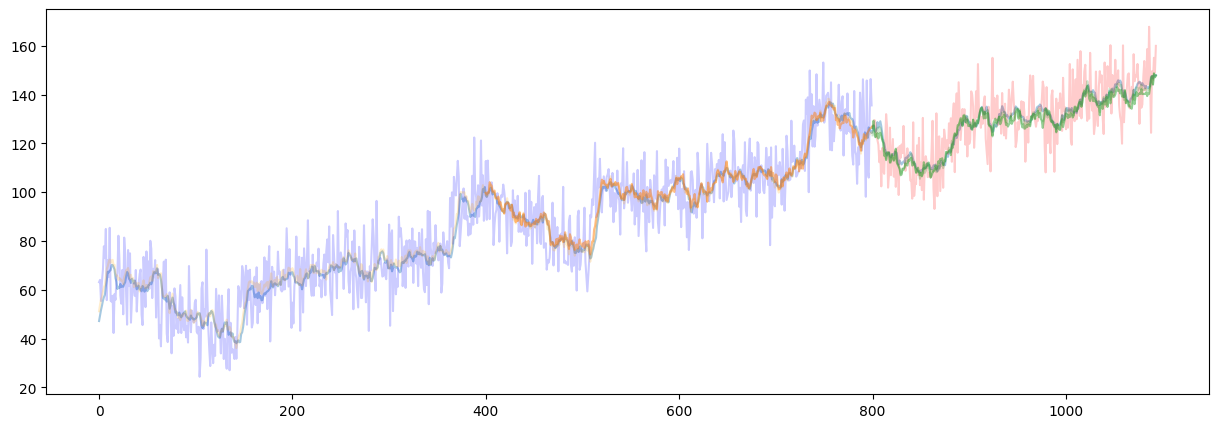

In [28]:
plt.figure(figsize=(15,5))
plt.plot(df_predict.index, df_predict['ma'], alpha=0.4)
plt.plot(X_train.index, y_train, color = "blue",alpha=0.2)
plt.plot(X_test.index, y_test, color = "r",alpha=0.2)

plt.plot(X_train.index, y_pred_trainv1, color = "orange",alpha=0.2)
plt.plot(X_test.index, y_pred_testv1, color = "g",alpha=0.2)

plt.plot(X_train[400:].index, y_pred_trainv2, alpha=0.5)
plt.plot(X_test.index, y_pred_testv2,alpha=0.5)

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA(n_components=0.95)
mm = MinMaxScaler()
X_mm_train = mm.fit_transform(X_train)
X_mm_test = mm.transform(X_test)
y_mm_train = mm.fit_transform(y_train.to_numpy().reshape(-1,1))
y_mm_test = mm.transform(y_test.to_numpy().reshape(-1,1))

X_pca_train = pca.fit_transform(scaler.fit_transform(X_train))
X_pca_test = pca.transform(scaler.transform(X_test))
df_pca_train = pd.DataFrame(X_pca_train)
df_pca_test = pd.DataFrame(X_pca_test)

In [23]:
cols = ['diff_rm_30','diff_rm_60','diff_rm_180','diff_rm_365','std_7','ma']
X_train.shape

(800, 51)

In [24]:
new_model = LinearRegression().fit(X_train[cols],y_train)
y_pred_trainv1 = new_model.predict(X_train[cols])
print(mean_absolute_error(y_train,y_pred=y_pred_trainv1))
y_pred_testv1 = new_model.predict(X_test[cols])
print(mean_absolute_error(y_test,y_pred=y_pred_testv1))

8.834944225433139
8.34186739988297


In [25]:
new_model = LinearRegression().fit(X_train[cols][400:],y_train[400:])
y_pred_trainv2 = new_model.predict(X_train[cols][400:])
print(mean_absolute_error(y_train[400:],y_pred=y_pred_trainv2))
y_pred_testv2 = new_model.predict(X_test[cols])
print(mean_absolute_error(y_test,y_pred=y_pred_testv2))

8.504001229164189
8.426762649865454


In [26]:
pca_model = LinearRegression().fit(df_pca_train,y_train)
y_pred_pca_trainv1 = pca_model.predict(df_pca_train)
print(mean_absolute_error(y_train,y_pred=y_pred_trainv1))
y_pred_pca_testv1 = pca_model.predict(X_pca_test)
print(mean_absolute_error(y_test,y_pred=y_pred_pca_testv1))

8.834944225433139
8.226140823532063


In [27]:
pca_model = LinearRegression().fit(df_pca_train.loc[400:],y_train[400:])
y_pred_pca_trainv2 = pca_model.predict(df_pca_train.loc[400:])
print(mean_absolute_error(y_train[400:],y_pred=y_pred_trainv2))
y_pred_pca_testv2 = pca_model.predict(X_pca_test)
print(mean_absolute_error(y_test,y_pred=y_pred_pca_testv2))

8.504001229164189
8.475888784847442


In [30]:
import torch
from torch import nn
import random
import os
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(10)


Random seed set as 10


In [44]:
class LinearRegressionModel(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=in_features, out_features=25)
        self.linear_layer_2 = nn.Linear(in_features=25, out_features=out_features)

    def forward(self, x: torch.Tensor):
        x1 = self.linear_layer_1(x)
        x2 = self.linear_layer_2(x1)
        return x2

# PyTorch Training Step
def train_Pytorch(model, X, y, X2, y2,epochs=3000):
    X = X.float()
    y= y.float()
    X2 = X2.float()
    y2 = y2.float()
    test_loss_check = 999
    loss_fn = nn.L1Loss() # MAE (Loss Function)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
    
    for epoch in range(epochs):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.inference_mode():
            test_pred = model(X2)
            test_loss = loss_fn(test_pred, y2)

        # if epoch % 50 == 0:
        #     print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        if test_loss < test_loss_check:
            test_loss_check = test_loss
            # print(test_loss_check)
            best_model = model
    print(f"Epoch: {epoch+1} | Train loss: {loss} | Test loss: {test_loss}")
    best_model.eval()
    with torch.inference_mode():
            test_pred_train = best_model(X)
            test_pred_test = best_model(X2)
    return test_pred_train,test_pred_test

In [46]:
model_nn = LinearRegressionModel(in_features=51,out_features=1)
a_train,a_test = train_Pytorch(
    model_nn,
    torch.from_numpy(X_mm_train[400:,:]), 
    torch.from_numpy(y_mm_train[400:]), 
    torch.from_numpy(X_mm_test), 
    torch.from_numpy(y_mm_test), 
    3000)

Epoch: 3000 | Train loss: 0.061899334192276 | Test loss: 0.06723231077194214


In [47]:
b_train = mm.inverse_transform(a_train)
b_test = mm.inverse_transform(a_test)
print(mean_absolute_error(y_train[400:],y_pred=b_train))
print(mean_absolute_error(y_test,y_pred=b_test))

7.9828103997383675
8.661843671164466


In [48]:
model_nn = LinearRegressionModel(in_features=51,out_features=1)
a_train,a_test = train_Pytorch(
    model_nn,
    torch.from_numpy(X_mm_train), 
    torch.from_numpy(y_mm_train), 
    torch.from_numpy(X_mm_test), 
    torch.from_numpy(y_mm_test), 
    3000)
b_train = mm.inverse_transform(a_train)
b_test = mm.inverse_transform(a_test)
print(mean_absolute_error(y_train,y_pred=b_train))
print(mean_absolute_error(y_test,y_pred=b_test))

Epoch: 3000 | Train loss: 0.06611809879541397 | Test loss: 0.06345492601394653
8.518106135964006
8.1751860379674


In [162]:
regr = SVR(kernel='rbf',max_iter=5000,degree=1)
new_model = regr.fit(X_train,y_train)
y_pred_trainv1 = new_model.predict(X_train)
print(mean_absolute_error(y_train,y_pred=y_pred_trainv1))
y_pred_testv1 = new_model.predict(X_test)
print(mean_absolute_error(y_test,y_pred=y_pred_testv1))

NameError: name 'SVR' is not defined

In [68]:
pca_model = LGBMRegressor(criterion='absolute_error').fit(df_pca_train,y_train)
y_pred_pca_trainv1 = pca_model.predict(df_pca_train)
print(mean_absolute_error(y_train,y_pred=y_pred_trainv1))
y_pred_pca_testv1 = pca_model.predict(X_pca_test)
print(mean_absolute_error(y_test,y_pred=y_pred_pca_testv1))

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 1
[LightGBM] [Info] Start training from score 84.176399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [69]:
pca_model = LGBMRegressor().fit(df_pca_train.loc[400:],y_train[400:])
y_pred_pca_trainv2 = pca_model.predict(df_pca_train.loc[400:])
print(mean_absolute_error(y_train[400:],y_pred=y_pred_trainv2))
y_pred_pca_testv2 = pca_model.predict(X_pca_test)
print(mean_absolute_error(y_test,y_pred=y_pred_pca_testv2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 1
[LightGBM] [Info] Start training from score 102.808391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [70]:
new_model = LGBMRegressor().fit(X_train[cols],y_train)
y_pred_trainv1 = new_model.predict(X_train[cols])
print(mean_absolute_error(y_train,y_pred=y_pred_trainv1))
y_pred_testv1 = new_model.predict(X_test[cols])
print(mean_absolute_error(y_test,y_pred=y_pred_testv1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 6
[LightGBM] [Info] Start training from score 84.176399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [23]:
# multicollinearity_assumption(base_model, X_train,y_train, X_train.columns)
# multicollinearity_assumption(new_model, X_train[cols],y_train, cols)
# multicollinearity_assumption(new_model, df_pca_train, y_train, df_pca_train.columns)

In [68]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [70]:
autocorrelation_assumption(base_model, X_train, y_train)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.000899109231744
Little to no autocorrelation 

Assumption satisfied
